[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pachterlab/OP_2025/blob/main/analysis_scripts/Partial_Correlation_Analysis.ipynb)

In [10]:
# import packages

import os, sys
sys.path.append('../')
from pathlib import Path

# numbers
import numpy as np
import pandas as pd

# sc
import anndata
import pingouin as pg

from rat_friend import *

from scipy import stats

import matplotlib.pyplot as plt
from pandas.plotting import table

In [2]:
os.chdir('/home/coakes/rat/')

# Load RNA and MetaData

In [3]:
omic = 'RNA'
adata = load_annotated_omic(f'omics_adata/rat_{omic}_meta.h5ad', omic)
# use the gene with the highest linear regression coeffecient as the "RNA" value
time_coeff = pd.read_csv('linear_regression_time_coeffs.csv')
goi, goi_tiss = time_coeff[time_coeff['abs_coeff'] == time_coeff['abs_coeff'].max()].feature.str.split('_').to_list()[0]
adata = adata[:,adata.var.X == goi]
adata = adata[adata.obs.tissue == goi_tiss]
goi, goi_tiss, adata

('ENSRNOG00000013552',
 'BAT',
 View of AnnData object with n_obs × n_vars = 49 × 1
     obs: 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'group', 'rank', 'nid', 'num_umi', 'outlier', 'original_out', 'old_tissue'
     var: 'X', 'omic'
     uns: 'X_name'
     layers: 'ambiguous', 'spliced', 'unspliced', 'counts')

In [4]:
obs_df = pd.DataFrame({
    'nid': adata.obs.nid.values,
    'gene': adata.X.toarray().T[0],
    'time': adata.obs.time.values,
    'fat': adata.obs['calculated.variables.pct_body_fat_change'].values,
    'vo2': adata.obs['calculated.variables.vo2_max_change'].values
    
})
obs_df=obs_df[~obs_df.isna().max(axis=1)]
obs_df.head(), obs_df.shape

(   nid     gene  time  fat   vo2
 4  F4R  25059.0     4 -0.4  1.12
 5  F4N   3702.0     4 -2.2  0.62
 6  M4I   1803.0     4 -1.2  4.47
 7  M4G   4223.0     4 -3.3  1.50
 8  M4F   4676.0     4 -2.1  2.02,
 (29, 5))

# Calculate Correlations between Physiological Data

In [5]:
type_list = ['time', 'fat', 'vo2']
corr_list = []
for i in type_list:
    corr = stats.pearsonr(obs_df['gene'], obs_df[i]).statistic
    print('gene', i, corr)
    corr_list += [corr]

gene time -0.35133503598146887
gene fat 0.591114214913668
gene vo2 -0.4219275755063084


In [6]:
for x in ['vo2', 'fat']:
    for y in ['fat', 'time']:
        if x != y:
            corr = stats.pearsonr(obs_df[x], obs_df[y]).statistic
            print(x, y, corr)
            corr_list += [corr]

vo2 fat -0.557592133176517
vo2 time 0.7789156624118547
fat time -0.6227984746880671


# Calculate Partial Correlations

In [7]:
partial_corrs = np.ones([4, 4])
for i in range(4):
    for j in range(4):
        feature_list = ['gene', 'vo2', 'fat', 'time']
        if i != j:
            var_1 = feature_list[i]
            var_2 = feature_list[j]
            feature_list.remove(var_1)
            feature_list.remove(var_2)
            partial_corrs[i,j] = pg.partial_corr(obs_df, x=var_1, y = var_2, covar=feature_list).r.iloc[0]
            
df = pd.DataFrame(partial_corrs, 
             columns = ['RNA', 'VO2', 'Body Fat', 'Weeks of Exercise'],
            index = ['RNA', 'VO2', 'Body Fat', 'Weeks of Exercise']
            )

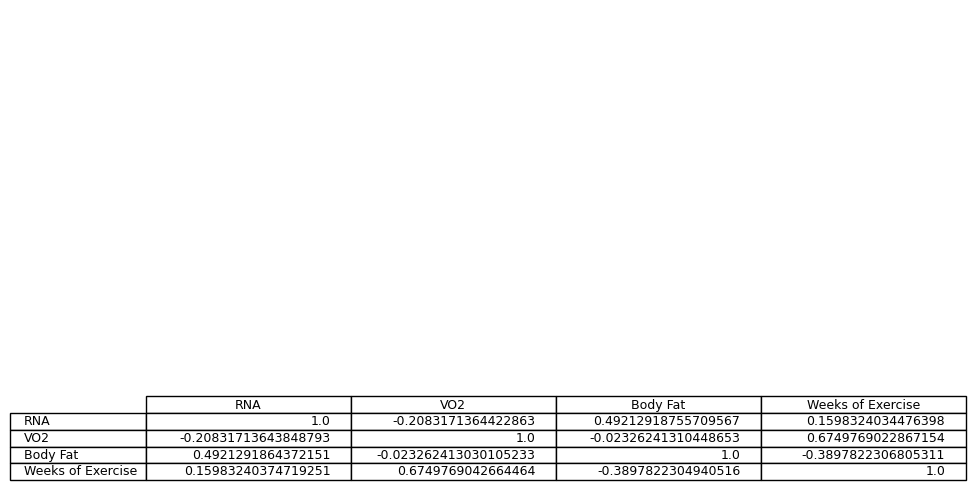

In [43]:
fig,ax = plt.subplots(figsize=(10,5))
ax.axis('off')

table(ax, df)  # where df is your data frame
plt.tight_layout()
plt.savefig('supplemental_table_1.png')